## Task 1: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.0 MB/s 
     |████████████████████████████████| 212 kB 66.5 MB/s 


In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.8.2


## Task 2: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [3]:
#Import Emotion Dataset
df=nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [4]:
#View Dataset
df

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [5]:
#Seperate Train, Test and Validation from Main Dataset
df_train=df['train']
df_test=df['test']
df_validation=df['validation']

In [6]:
#Defining a function to extract tweet and label columns
def extract_tweet(data):
  tweets=[x['text'] for x in data]
  labels=[x['label'] for x in data]
  return tweets, labels

In [82]:
train_tweets, labels=extract_tweet(df_train)
test_tweets, test_labels=extract_tweet(df_test)
valid_tweets, valid_labels=extract_tweet(df_validation)

#View first tweet and label in training set
train_tweets[0], labels[0]

('i didnt feel humiliated', 'sadness')

## Task 3: Tokenizer

1. Tokenizing the tweets

In [49]:
# Importing Tokenizer from TensorFlow
from tensorflow.keras.preprocessing.text import Tokenizer

In [50]:
#first create an object
tokenizer=Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(train_tweets)

In [51]:
train_tweets[3]

'i am ever feeling nostalgic about the fireplace i will know that it is still on the property'

In [52]:
tokenizer.texts_to_sequences([train_tweets[3]])

[[2, 24, 165, 8, 665, 27, 6, 4158, 2, 59, 47, 9, 13, 22, 72, 30, 6, 3497]]

## Task 4: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

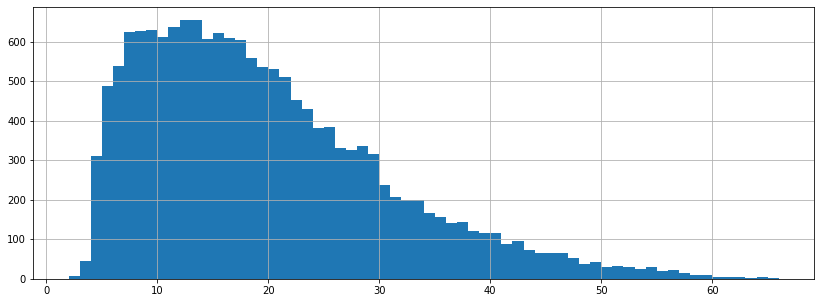

In [53]:
lengths=[len(t.split(' ')) for t in train_tweets]
plt.figure(figsize=(14,5))
plt.hist(lengths,bins=len(set(lengths)))
plt.grid()
plt.show()

In [54]:
#importing the Library
from tensorflow.keras.preprocessing.sequence import pad_sequences

max=50
#length higher than max will be truncated


In [55]:
#Defining a function that will help us in truncation and padding
def seq(tokenizer,tweets):
  sequences=tokenizer.texts_to_sequences(tweets)
  padded=pad_sequences(sequences, truncating='post', padding='post', maxlen=max)
  return padded

In [56]:
train_sequence_padded=seq(tokenizer,train_tweets)
train_sequence_padded[3]

array([   2,   24,  165,    8,  665,   27,    6, 4158,    2,   59,   47,
          9,   13,   22,   72,   30,    6, 3497,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

## Task 5: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [58]:
classes=set(labels)
classes

{'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'}

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


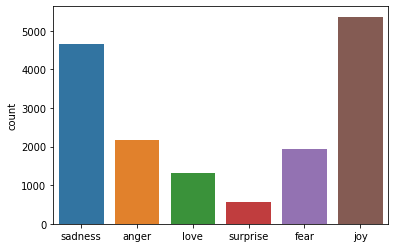

In [61]:
import seaborn as sns
sns.countplot(labels);

In [62]:
class_to_index=dict((c,i) for i ,c in enumerate(classes))
index_to_class=dict((v,k) for k ,v in class_to_index.items())
#lets view the labels and index
class_to_index

{'love': 0, 'fear': 1, 'joy': 2, 'surprise': 3, 'sadness': 4, 'anger': 5}

In [63]:
index_to_class

{0: 'love', 1: 'fear', 2: 'joy', 3: 'surprise', 4: 'sadness', 5: 'anger'}

In [64]:
names_to_ids=lambda labels: np.array([class_to_index.get(x) for x in labels])

In [65]:
train_labels=names_to_ids(labels)
train_labels

array([4, 4, 5, ..., 2, 5, 4])

## Task 6: Creating the Model

1. Creating the model
2. Compiling the model

In [66]:
model=tf.keras.Sequential([
    tf.keras.layers.Embedding(10000,16,input_length=max),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [67]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [68]:
#valid_tweets, valid_labels
valid_seq=seq(tokenizer,valid_tweets)
valid_labels=names_to_ids(valid_labels)

In [69]:
valid_tweets[4],valid_labels[4]

('i can have for a treat or if i am feeling festive', 2)

In [73]:
history=model.fit(train_sequence_padded,train_labels,
                  validation_data=(valid_seq,valid_labels),
                  epochs=100,
                  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2)])

Epoch 1/100
500/500 [==============================] - 16s 15ms/step - loss: 1.3837 - accuracy: 0.4154 - val_loss: 0.8956 - val_accuracy: 0.6600
Epoch 2/100
500/500 [==============================] - 7s 13ms/step - loss: 0.6460 - accuracy: 0.7682 - val_loss: 0.5755 - val_accuracy: 0.8055
Epoch 3/100
500/500 [==============================] - 6s 12ms/step - loss: 0.3688 - accuracy: 0.8794 - val_loss: 0.4898 - val_accuracy: 0.8560
Epoch 4/100
500/500 [==============================] - 6s 12ms/step - loss: 0.2339 - accuracy: 0.9303 - val_loss: 0.4266 - val_accuracy: 0.8655
Epoch 5/100
500/500 [==============================] - 6s 12ms/step - loss: 0.1773 - accuracy: 0.9459 - val_loss: 0.3972 - val_accuracy: 0.8860
Epoch 6/100
500/500 [==============================] - 6s 12ms/step - loss: 0.1359 - accuracy: 0.9588 - val_loss: 0.4198 - val_accuracy: 0.8825
Epoch 7/100
500/500 [==============================] - 6s 12ms/step - loss: 0.1097 - accuracy: 0.9644 - val_loss: 0.4131 - val_accuracy

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

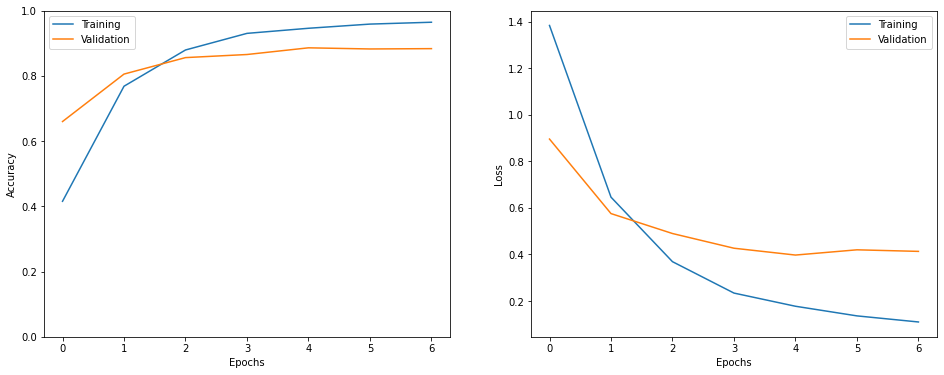

In [74]:
show_history(history)

In [83]:
test_seq=seq(tokenizer,test_tweets)
test_label=names_to_ids(test_labels)
test_label

array([4, 4, 4, ..., 2, 2, 1])

In [84]:
model.evaluate(test_seq,test_label)

63/63 [==============================] - 0s 7ms/step - loss: 0.3758 - accuracy: 0.8865


[0.37581807374954224, 0.8865000009536743]

In [97]:
pred=np.argmax(model.predict(test_seq),axis=-1)
pred

array([4, 4, 4, ..., 2, 2, 1])

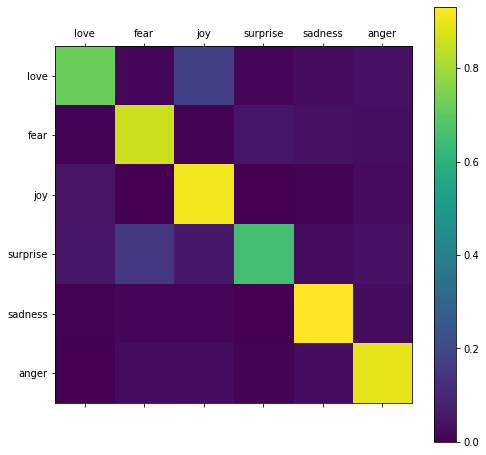

In [100]:
show_confusion_matrix(test_label,pred,list(classes))